## **Inteligencia Artificial y Aprendizaje Automático**

## **Carlos Alvarez**

### Prof Luis Eduardo Falcón Morales

## **Modelos sobre datos de Series de Tiempo: Ingenuo / SARIMA / Prophet / LSTM**

Análisis sobre datos históricos de las acciones de Tesla diarios en los últimos 5 años

# **0 - Preparando los datos**

In [1]:
# Se omiten los Warnings por el momento:
#import warnings
#warnings.filterwarnings("ignore")

In [2]:
#!pip freeze   # Si deseas verificar qué librerías y versiones ya tiene google-Colab preinstaladas,
               # en particular "prophet" que usaremos en este ejercicio.

In [3]:
# Importación de Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
import math

from prophet import Prophet
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # gráficos de autocorrelación
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Importación de los datos
import yfinance as yf   # Importamos las bibliotecas requeridas.
ticker_symbol = 'TSLA'   # selecciona las iniciales de la compañía deseada.
data = yf.download(ticker_symbol, period='5y')   # Se indica el período y descargamos.
data.to_csv('historical_data.csv')   # Guardamos los datos

[*********************100%***********************]  1 of 1 completed


La columna "Adj Closed" es el precio de cierre ajustado de una acción.

A diferencia del precio de cierre regular, el precio ajustado toma en cuenta eventos corporativos como dividendos, desdoblamientos de acciones (splits) y otras distribuciones.

Esto ofrece una visión más precisa del valor real de una acción, ya que refleja los cambios en el valor que afectan a los inversionistas a largo plazo.

In [5]:
path = 'historical_data.csv'
df = pd.read_csv(path, header=0)

# Elimina los primeros dos renglones
df = df.iloc[2:].reset_index(drop=True)

# Renombra la primera columna a 'Date'
df.columns.values[0] = 'Date'

df = df[['Date', 'Adj Close']]
df.head()

,Date,Adj Close
0,2019-11-13 00:00:00+00:00,23.073999404907227
1,2019-11-14 00:00:00+00:00,23.290000915527344
2,2019-11-15 00:00:00+00:00,23.47800064086914
3,2019-11-18 00:00:00+00:00,23.332666397094727
4,2019-11-19 00:00:00+00:00,23.968000411987305


In [6]:
df.info() #La columna Date es de tipo object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       1258 non-null   object
 1   Adj Close  1258 non-null   object
dtypes: object(2)
memory usage: 19.8+ KB


In [7]:
# Renombremos de manera estándar las columnas de fechas y valores de la
# serie de tiempo, donde además la fecha la trasnformamos a tipo datetime:

df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])
df['y'] = pd.to_numeric(df['y'], errors='coerce')

df.head()

,ds,y
0,2019-11-13 00:00:00+00:00,23.073999
1,2019-11-14 00:00:00+00:00,23.290001
2,2019-11-15 00:00:00+00:00,23.478001
3,2019-11-18 00:00:00+00:00,23.332666
4,2019-11-19 00:00:00+00:00,23.968000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   ds      1258 non-null   datetime64[ns, UTC]
 1   y       1258 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 19.8 KB


### **Agreguemos los ajustes usuales en Series de tiempo:**

In [9]:
# Hagamos una copia del DataFrame df con índices temporales:
df_temp = df.copy()
df_temp.set_index('ds', inplace=True)
df_temp

,y
ds,
2019-11-13 00:00:00+00:00,23.073999
2019-11-14 00:00:00+00:00,23.290001
2019-11-15 00:00:00+00:00,23.478001
2019-11-18 00:00:00+00:00,23.332666
2019-11-19 00:00:00+00:00,23.968000
...,...
2024-11-06 00:00:00+00:00,288.529999
2024-11-07 00:00:00+00:00,296.910004
2024-11-08 00:00:00+00:00,321.220001


In [11]:
df.shape

(1258, 2)


Información sobre index en Pandas:
https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html




In [12]:
# Ajustemos la frecuencia de los índices, para que el modelo tenga información del período en que
# se encuentran los datos:

df_temp.index  # Observamos que aquí todavía no se tiene información del argumento "freq"

DatetimeIndex(['2019-11-13 00:00:00+00:00', '2019-11-14 00:00:00+00:00',
               '2019-11-15 00:00:00+00:00', '2019-11-18 00:00:00+00:00',
               '2019-11-19 00:00:00+00:00', '2019-11-20 00:00:00+00:00',
               '2019-11-21 00:00:00+00:00', '2019-11-22 00:00:00+00:00',
               '2019-11-25 00:00:00+00:00', '2019-11-26 00:00:00+00:00',
               ...
               '2024-10-30 00:00:00+00:00', '2024-10-31 00:00:00+00:00',
               '2024-11-01 00:00:00+00:00', '2024-11-04 00:00:00+00:00',
               '2024-11-05 00:00:00+00:00', '2024-11-06 00:00:00+00:00',
               '2024-11-07 00:00:00+00:00', '2024-11-08 00:00:00+00:00',
               '2024-11-11 00:00:00+00:00', '2024-11-12 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='ds', length=1258, freq=None)

Para las opciones de "freq" ver la tabla que viene en esta liga:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [13]:
# Especifiquemos entonces que nuestros datos están registrados con una diaria
# Cada dia
df_temp = df_temp.asfreq('B') #business day frequency o B, coloca como NAN los valores faltantes

df_temp.index

DatetimeIndex(['2019-11-13 00:00:00+00:00', '2019-11-14 00:00:00+00:00',
               '2019-11-15 00:00:00+00:00', '2019-11-18 00:00:00+00:00',
               '2019-11-19 00:00:00+00:00', '2019-11-20 00:00:00+00:00',
               '2019-11-21 00:00:00+00:00', '2019-11-22 00:00:00+00:00',
               '2019-11-25 00:00:00+00:00', '2019-11-26 00:00:00+00:00',
               ...
               '2024-10-30 00:00:00+00:00', '2024-10-31 00:00:00+00:00',
               '2024-11-01 00:00:00+00:00', '2024-11-04 00:00:00+00:00',
               '2024-11-05 00:00:00+00:00', '2024-11-06 00:00:00+00:00',
               '2024-11-07 00:00:00+00:00', '2024-11-08 00:00:00+00:00',
               '2024-11-11 00:00:00+00:00', '2024-11-12 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='ds', length=1305, freq='B')

In [14]:
#Para no dejar valores NAN imputaremos con los valores del dia anterior
df_temp.ffill(inplace = True) #ffill toma el ultimo valor no nullo y lo coloca en las filas con valores nulos

In [15]:
df_temp.isnull().sum() #Ya no hay valores nulos

,0
y,0


In [16]:
# Particionemos en entrenamiento y prueba como DataFrames de Pandas:

# Definir el tamaño del conjunto de prueba
test_size = 20

# Dividir el dataframe en Train y Test
train = df_temp[:-test_size]
test = df_temp[-test_size:]


In [17]:
#Conjunto de entrenamiento
train.shape

(1285, 1)

In [18]:
#Conjunto de prueba
test.shape

(20, 1)

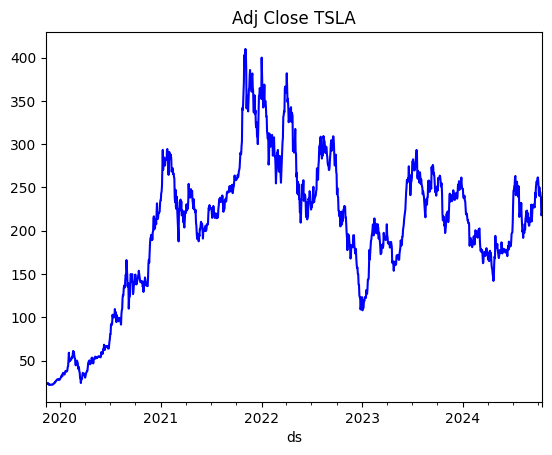

In [19]:
# Gráfico con la periodicidad diaria:
train['y'].plot(title='Adj Close TSLA', style='-b')
plt.show()

De este gráfico podemos observar:

1.    Que no existe una tendencia marcada a partir del 2021 es un tanto impredecible. Sin embargo se observa cierta periodicidad.

2.   Este modelo podria adaptarse mejor a un aditivo.

In [20]:
#Para manejar datos escalados se agrega una columna al dataframe.
# Crear el escalador
scaler = MinMaxScaler(feature_range=(0, 1))

# Escalar la columna 'y' y crear una nueva columna 'y_escalada'
df_temp['y_escalada'] = scaler.fit_transform(df_temp[['y']])

#se vuelven a generar datos de entrenamiento y prueba

# Dividir el dataframe en Train y Test
train = df_temp[:-test_size]
test = df_temp[-test_size:]

# Ver el dataframe con la columna escalada
print(df_temp)

                                    y  y_escalada
ds                                               
2019-11-13 00:00:00+00:00   23.073999    0.002953
2019-11-14 00:00:00+00:00   23.290001    0.003510
2019-11-15 00:00:00+00:00   23.478001    0.003994
2019-11-18 00:00:00+00:00   23.332666    0.003620
2019-11-19 00:00:00+00:00   23.968000    0.005257
...                               ...         ...
2024-11-06 00:00:00+00:00  288.529999    0.687044
2024-11-07 00:00:00+00:00  296.910004    0.708640
2024-11-08 00:00:00+00:00  321.220001    0.771288
2024-11-11 00:00:00+00:00  350.000000    0.845455
2024-11-12 00:00:00+00:00  328.489990    0.790023

[1305 rows x 2 columns]


# **1 - Modelo ingenuo (Baseline / Persistance / Naive model)**

*   El modelo ingenuo simplemente hace la predicción del siguiente perídodo, repitiendo el valor del último período.

*   Este modelo se utiliza en general como punto de partida para comparar todos los demás,

*   Utilicemos el error RMSE (Raíz del Error Cuadrático Medio) como medida del desempeño de nuestros modelos a obtener.

In [ ]:
test['y'].values

array([219.57000732, 221.33000183, 220.88999939, 220.69999695,
       218.8500061 , 217.97000122, 213.6499939 , 260.48001099,
       269.19000244, 262.51000977, 259.51998901, 257.54998779,
       249.8500061 , 248.97999573, 242.83999634, 251.44000244,
       288.52999878, 296.91000366, 321.22000122, 350.        ])

In [ ]:
test['y_escalada'].values

array([0.50933148, 0.51386706, 0.51273316, 0.51224351, 0.50747601,
       0.5052082 , 0.49407537, 0.61475822, 0.63720422, 0.61998961,
       0.61228421, 0.60720743, 0.58736427, 0.58512222, 0.56929919,
       0.59146175, 0.68704418, 0.70863979, 0.77128765, 0.84545487])

In [ ]:
# Definir "history" para ambas columnas
history_y = [x for x in train['y'].values]   # Historial de la columna 'y'
history_escalada = [x for x in train['y_escalada'].values]  # Historial de la columna 'y_escalada'

# Lista para contener las predicciones
predictions_y_naives = list()    # Predicciones para la columna 'y'
predictions_escalada_naives = list()  # Predicciones para la columna 'y_escalada'

# Realizar predicciones para el conjunto de prueba
for i in range(len(test['y'])):
    # Predicciones para 'y'
    yhat_y = history_y[-1]   # Tomamos el último valor de 'y' en el historial
    predictions_y_naives.append(yhat_y)

    # Predicciones para 'y_escalada'
    yhat_escalada = history_escalada[-1]   # Tomamos el último valor de 'y_escalada' en el historial
    predictions_escalada_naives.append(yhat_escalada)

    # Obtenemos las observaciones reales
    obs_y = test.iloc[i]['y']   # Dato real de 'y'
    obs_escalada = test.iloc[i]['y_escalada']  # Dato real de 'y_escalada'

    # Añadimos los valores observados a los historiales
    history_y.append(obs_y)
    history_escalada.append(obs_escalada)

    print(f'>Esperado-real (y) = {obs_y:.3f}, Predicción (y) = {yhat_y:.3f}')
    print(f'>Esperado-real (y_escalada) = {obs_escalada:.3f}, Predicción (y_escalada) = {yhat_escalada:.3f}')



# Calcular RMSE para 'y'
rmse_y = np.sqrt(mean_squared_error(test['y'].values, predictions_y_naives))
print(f'\nError-Modelo-Naive para "y": RMSE: {rmse_y:.3f}')

# Calcular RMSE para 'y_escalada'
rmse_escalada = np.sqrt(mean_squared_error(test['y_escalada'].values, predictions_escalada_naives))
print(f'Error-Modelo-Naive para "y_escalada": RMSE: {rmse_escalada:.3f}')

>Esperado-real (y) = 219.570, Predicción (y) = 219.160
>Esperado-real (y_escalada) = 0.509, Predicción (y_escalada) = 0.508
>Esperado-real (y) = 221.330, Predicción (y) = 219.570
>Esperado-real (y_escalada) = 0.514, Predicción (y_escalada) = 0.509
>Esperado-real (y) = 220.890, Predicción (y) = 221.330
>Esperado-real (y_escalada) = 0.513, Predicción (y_escalada) = 0.514
>Esperado-real (y) = 220.700, Predicción (y) = 220.890
>Esperado-real (y_escalada) = 0.512, Predicción (y_escalada) = 0.513
>Esperado-real (y) = 218.850, Predicción (y) = 220.700
>Esperado-real (y_escalada) = 0.507, Predicción (y_escalada) = 0.512
>Esperado-real (y) = 217.970, Predicción (y) = 218.850
>Esperado-real (y_escalada) = 0.505, Predicción (y_escalada) = 0.507
>Esperado-real (y) = 213.650, Predicción (y) = 217.970
>Esperado-real (y_escalada) = 0.494, Predicción (y_escalada) = 0.505
>Esperado-real (y) = 260.480, Predicción (y) = 213.650
>Esperado-real (y_escalada) = 0.615, Predicción (y_escalada) = 0.494
>Esperad

#### **Este valor de predicción RMSE nos dice que en promedio el error es de aproximadamente más menos 15 (sin escalar) y 0.03(datos escalados) por cada predicción hecha para el valor de "Adj. Close". Este será nuestro error RMSE a mejorar.**

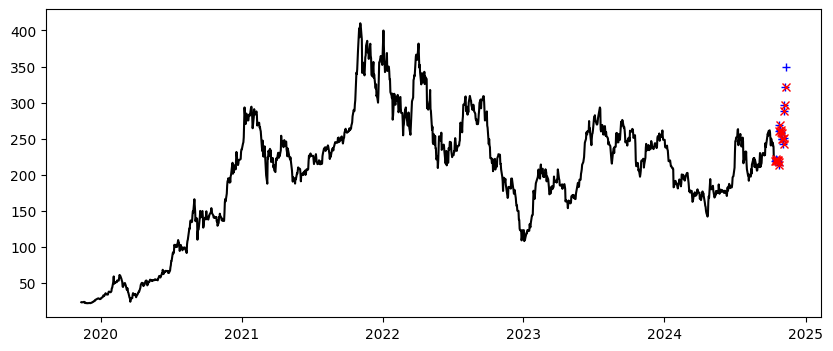

In [ ]:
# Grafiquemos los resultados para datos NO escalados:

fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')  # Datos de entrenamiento.
ax = plt.plot(test['y'], '+b')    # Datos de prueba reales (ultimos 20 datos).
ax = plt.plot(test.index,  predictions_y_naives, 'xr')  # Predicciones del modelo ingenuo para los ultimos 20 datos.

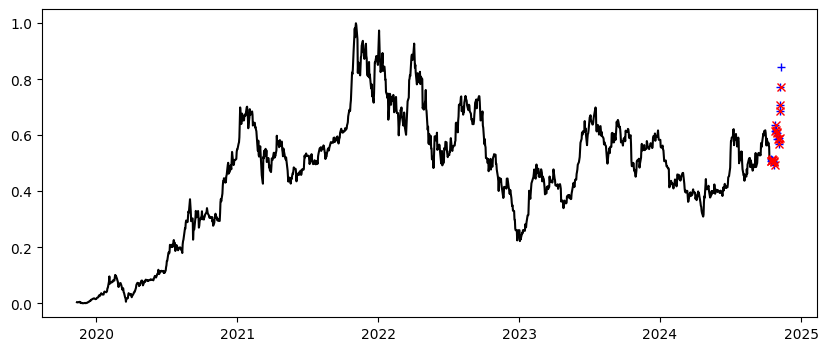

In [ ]:
# Grafiquemos los resultados para datos escalados:

fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y_escalada'], '-k')  # Datos de entrenamiento.
ax = plt.plot(test['y_escalada'], '+b')    # Datos de prueba reales (ultimos 20 datos).
ax = plt.plot(test.index,  predictions_escalada_naives, 'xr')  # Predicciones del modelo ingenuo para los ultimos 20 datos.

# **2 - Modelo ARIMA**

### **Análisis preliminar para obtener información de la serie de tiempo y construir el modelo ARIMA(p,d,q).**

*   **AR (AutoRegresivo):** El modelo se basa en la relación entre un valor actual y sus valores pasados.

*   **I (Integrado):** Se refiere a la diferenciación de la serie para hacerla estacionaria, es decir, eliminar tendencias y patrones cíclicos.

*   **MA (Media Móvil):** Usa el error de los valores pasados (las desviaciones entre valores predichos y observados) para corregir el valor actual.

<ipython-input-547-bc78b2fa120e>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  decomposition = seasonal_decompose(train['y'].resample('M').mean(), model='additive')  # <<<---- se selecciona el valor aditivo


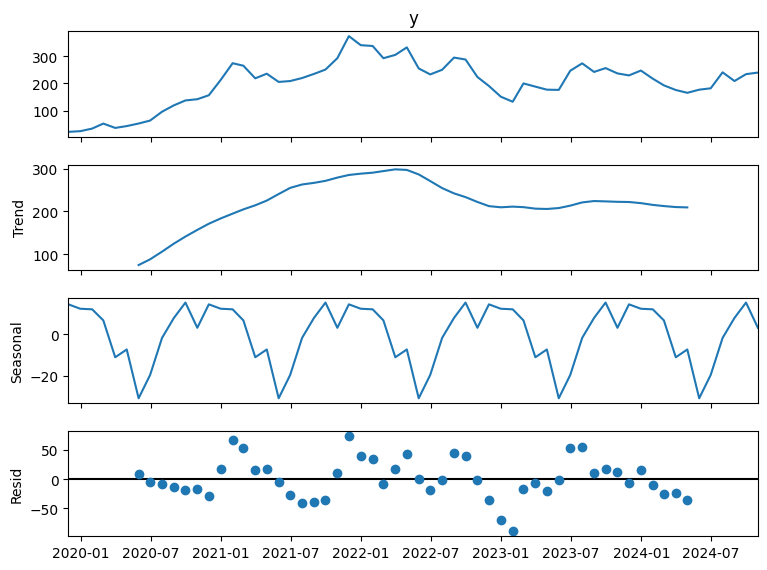

In [ ]:
# Gráficos de descomposición estacional para datos NO escalados:
decomposition = seasonal_decompose(train['y'].resample('M').mean(), model='additive')  # <<<---- se selecciona el valor aditivo
fig = decomposition.plot()
fig.set_size_inches(8,6)
plt.show()

<ipython-input-548-0cdbc173afdc>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  decomposition = seasonal_decompose(train['y_escalada'].resample('M').mean(), model='additive')  # <<<---- se selecciona el valor aditivo


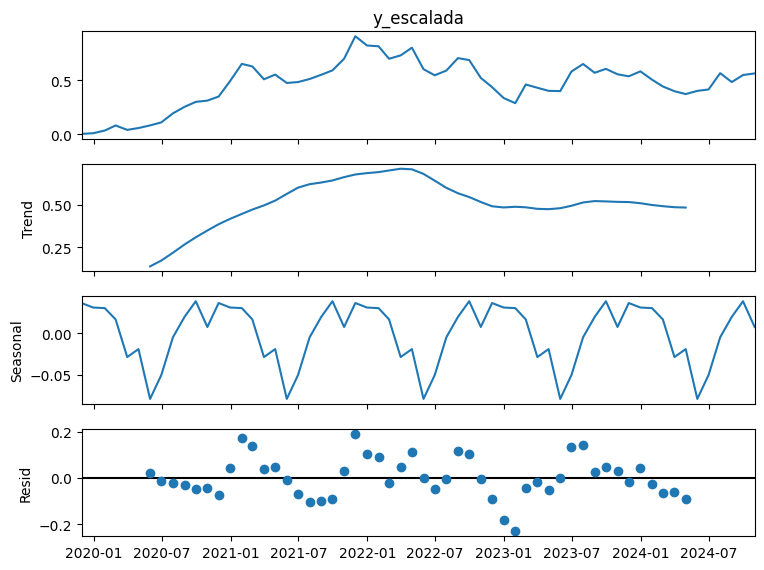

In [ ]:
# Gráficos de descomposición estacional para datos NO escalados:
decomposition = seasonal_decompose(train['y_escalada'].resample('M').mean(), model='additive')  # <<<---- se selecciona el valor aditivo
fig = decomposition.plot()
fig.set_size_inches(8,6)
plt.show()

<ipython-input-549-a342bf87a236>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_plot(train['y'].resample('M').mean(), ax=axes[0], ylabel='Pasajeros (y)')
<ipython-input-549-a342bf87a236>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  month_plot(train['y_escalada'].resample('M').mean(), ax=axes[1], ylabel='Pasajeros Escalados (y_escalada)')


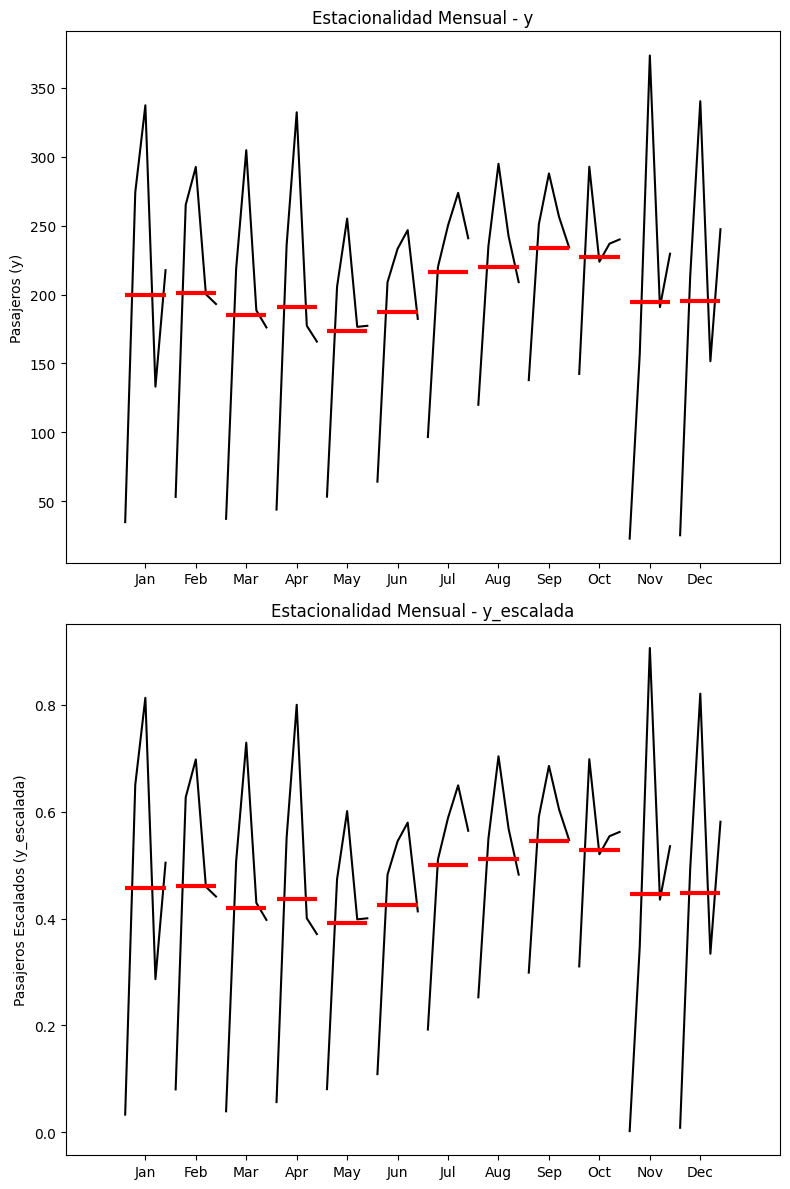

In [ ]:
# Gráfica para detección de estacionalidad mensual para 'y' y 'y_escalada':

# Crear figura con dos subgráficas (una para 'y' y otra para 'y_escalada')
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Gráfico de estacionalidad mensual para 'y'
month_plot(train['y'].resample('M').mean(), ax=axes[0], ylabel='Pasajeros (y)')
axes[0].set_title('Estacionalidad Mensual - y')

# Gráfico de estacionalidad mensual para 'y_escalada'
month_plot(train['y_escalada'].resample('M').mean(), ax=axes[1], ylabel='Pasajeros Escalados (y_escalada)')
axes[1].set_title('Estacionalidad Mensual - y_escalada')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

<ipython-input-550-7134c27b1db2>:6: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(train['y'].resample('Q').mean(), ax=axes[0], ylabel='Pasajeros (y)')
<ipython-input-550-7134c27b1db2>:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_plot(train['y_escalada'].resample('Q').mean(), ax=axes[1], ylabel='Pasajeros Escalados (y_escalada)')


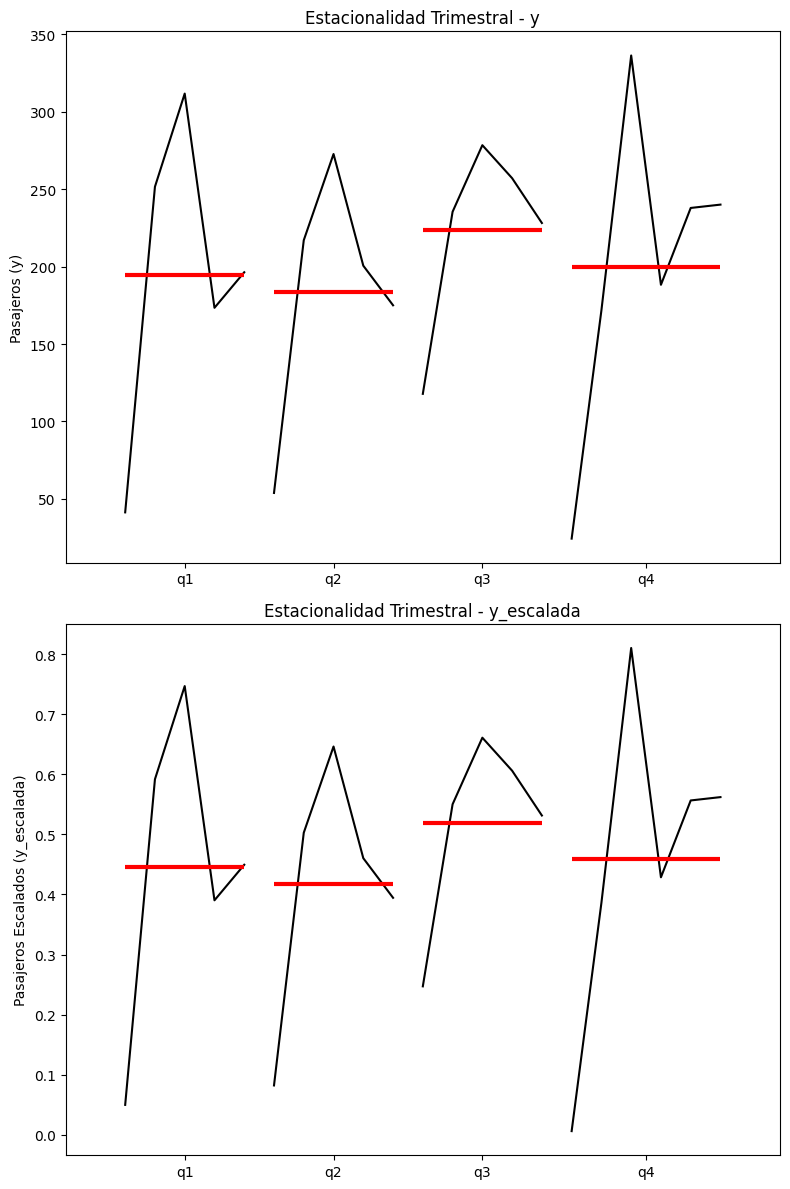

In [ ]:
# Si queremos graficar y detectar estacionalidad trimestral:
# Crear figura con dos subgráficas, una para 'y' y otra para 'y_escalada'
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Gráfico de estacionalidad trimestral para 'y'
quarter_plot(train['y'].resample('Q').mean(), ax=axes[0], ylabel='Pasajeros (y)')
axes[0].set_title('Estacionalidad Trimestral - y')

# Gráfico de estacionalidad trimestral para 'y_escalada'
quarter_plot(train['y_escalada'].resample('Q').mean(), ax=axes[1], ylabel='Pasajeros Escalados (y_escalada)')
axes[1].set_title('Estacionalidad Trimestral - y_escalada')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

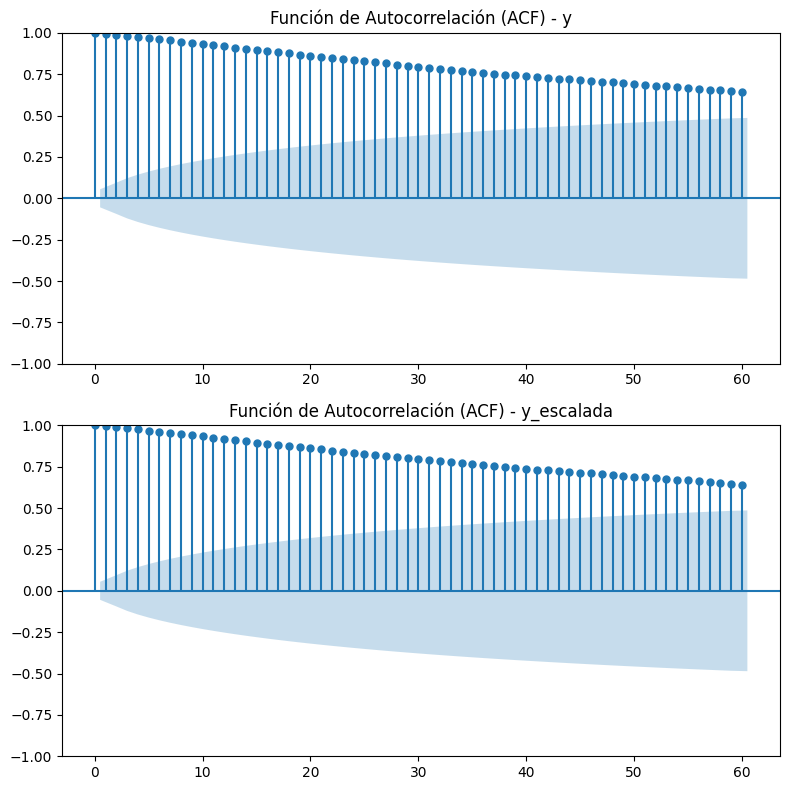

In [ ]:
# Gráfico de Autocorrelación (ACF: Auto-Correlation-Function)
# Crear figura con dos subgráficas, una para 'y' y otra para 'y_escalada'
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Gráfico de autocorrelación para 'y'
plot_acf(train['y'], lags=60, ax=axes[0])   # Elige 60 lags, ajustable según las necesidades
axes[0].set_title('Función de Autocorrelación (ACF) - y')

# Gráfico de autocorrelación para 'y_escalada'
plot_acf(train['y_escalada'], lags=60, ax=axes[1])
axes[1].set_title('Función de Autocorrelación (ACF) - y_escalada')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

  Según la grafica con un valor de lag de 3 a 5 sería suficiente para predecir los valores siguientes.

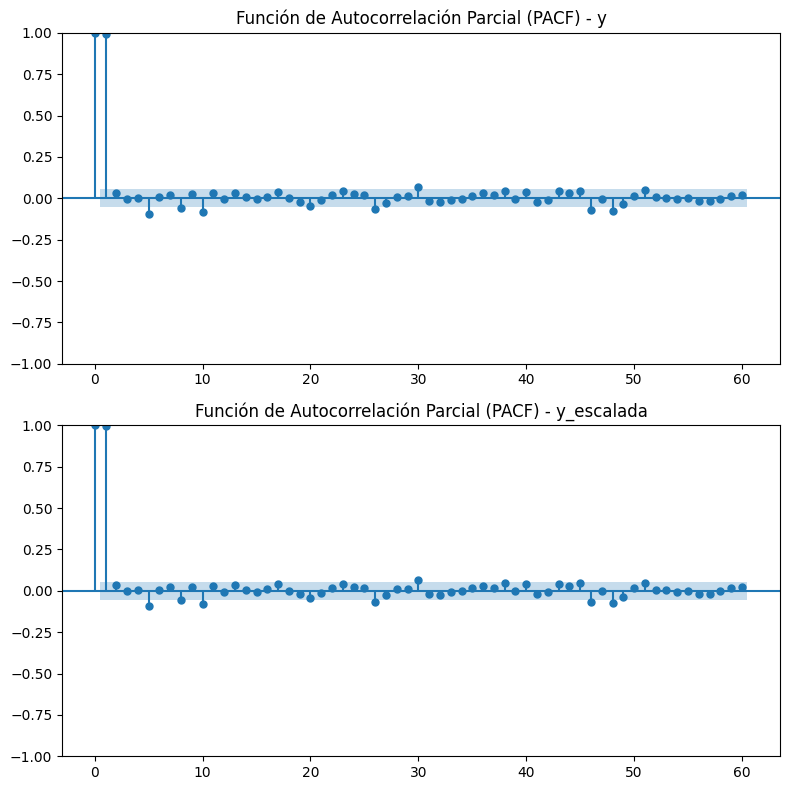

In [ ]:
# Gráfico de Autocorrelación Parcial (PACF):
# Crear figura con dos subgráficas, una para 'y' y otra para 'y_escalada'
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# Gráfico de autocorrelación parcial para 'y'
plot_pacf(train['y'], lags=60, ax=axes[0], method="ols")  # Usa el método "ols" para la regresión de series temporales
axes[0].set_title('Función de Autocorrelación Parcial (PACF) - y')

# Gráfico de autocorrelación parcial para 'y_escalada'
plot_pacf(train['y_escalada'], lags=60, ax=axes[1], method="ols")
axes[1].set_title('Función de Autocorrelación Parcial (PACF) - y_escalada')

# Mostrar las gráficas
plt.tight_layout()
plt.show()

No se observa periodicidad clara ni correlaciones significativas en el intervalo de tiempo


Según la gráfica seleccionan los valores:

p=3,
q=10,
d=0,

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Función para diferenciar la serie temporal
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# Función para revertir la diferenciación
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]  # Regresa la estacionalidad original

In [ ]:
# Lista de registros para 'y' y 'y_escalada'
history_y = [x for x in train['y'].values]
history_y_escalada = [x for x in train['y_escalada'].values]

predictions_y = list()
predictions_y_escalada = list()

for i in range(len(test)):
    # Para 'y'
    diff_y = difference(history_y)  # Diferenciamos para 'y'

    # Modelo ARIMA para 'y'
    model_y = ARIMA(diff_y, order=(3, 0, 13))
    model_fit_y = model_y.fit(method_kwargs={'maxiter': 500})

    yhat_y = model_fit_y.forecast()[0]  # Predicción para 'y'
    yhat_y = inverse_difference(history_y, yhat_y)
    predictions_y.append(yhat_y)

    # Observación real para 'y'
    obs_y = test.iloc[i]['y']
    history_y.append(obs_y)  # Añadir la observación real a 'history_y'

    print(f'>Esperado-real (y) = {obs_y:.3f}, Predicción (y) = {yhat_y:.3f}')

    # Para 'y_escalada'
    diff_y_escalada = difference(history_y_escalada)  # Diferenciamos para 'y_escalada'

    # Modelo ARIMA para 'y_escalada'
    model_y_escalada = ARIMA(diff_y_escalada, order=(3, 0, 13))
    model_fit_y_escalada = model_y_escalada.fit(method_kwargs={'maxiter': 500})

    yhat_y_escalada = model_fit_y_escalada.forecast()[0]  # Predicción para 'y_escalada'
    yhat_y_escalada = inverse_difference(history_y_escalada, yhat_y_escalada)
    predictions_y_escalada.append(yhat_y_escalada)

    # Observación real para 'y_escalada'
    obs_y_escalada = test.iloc[i]['y_escalada']
    history_y_escalada.append(obs_y_escalada)  # Añadir la observación real a 'history_y_escalada'

    print(f'>Esperado-real (y_escalada) = {obs_y_escalada:.3f}, Predicción (y_escalada) = {yhat_y_escalada:.3f}')

# Calcular el RMSE para 'y'
rmse_y = np.sqrt(mean_squared_error(test['y'].values, predictions_y))
print(f'\nError-Modelo-ARIMA para y: RMSE: {rmse_y:.3f}')

# Calcular el RMSE para 'y_escalada'
rmse_y_escalada = np.sqrt(mean_squared_error(test['y_escalada'].values, predictions_y_escalada))
print(f'\nError-Modelo-ARIMA para y_escalada: RMSE: {rmse_y_escalada:.3f}')

>Esperado-real (y) = 219.570, Predicción (y) = 218.571
>Esperado-real (y_escalada) = 0.509, Predicción (y_escalada) = 0.507
>Esperado-real (y) = 221.330, Predicción (y) = 219.046
>Esperado-real (y_escalada) = 0.514, Predicción (y_escalada) = 0.508
>Esperado-real (y) = 220.890, Predicción (y) = 221.292
>Esperado-real (y_escalada) = 0.513, Predicción (y_escalada) = 0.513
>Esperado-real (y) = 220.700, Predicción (y) = 220.693
>Esperado-real (y_escalada) = 0.512, Predicción (y_escalada) = 0.511
>Esperado-real (y) = 218.850, Predicción (y) = 221.108
>Esperado-real (y_escalada) = 0.507, Predicción (y_escalada) = 0.513
>Esperado-real (y) = 217.970, Predicción (y) = 217.012
>Esperado-real (y_escalada) = 0.505, Predicción (y_escalada) = 0.503
>Esperado-real (y) = 213.650, Predicción (y) = 218.572
>Esperado-real (y_escalada) = 0.494, Predicción (y_escalada) = 0.507
>Esperado-real (y) = 260.480, Predicción (y) = 212.962
>Esperado-real (y_escalada) = 0.615, Predicción (y_escalada) = 0.492
>Esperad

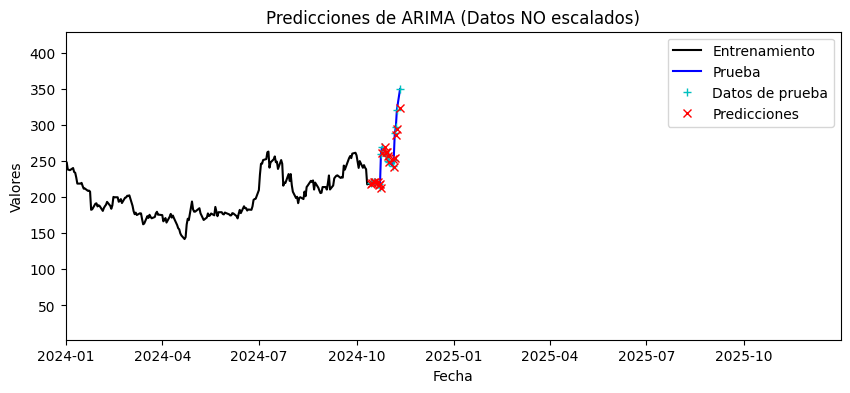

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

# Graficamos las series de datos
ax.plot(train['y'], '-k', label='Entrenamiento')
ax.plot(test['y'], '-b', label='Prueba')
ax.plot(test['y'], '+c', label='Datos de prueba')
ax.plot(test.index, predictions_y, 'xr', label='Predicciones')

# Establecemos los límites de fechas en el eje x
ax.set_xlim(['2024-01-01', '2025-12-31'])

# Añadimos etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Valores')
ax.set_title('Predicciones de ARIMA (Datos NO escalados)')
ax.legend()

plt.show()

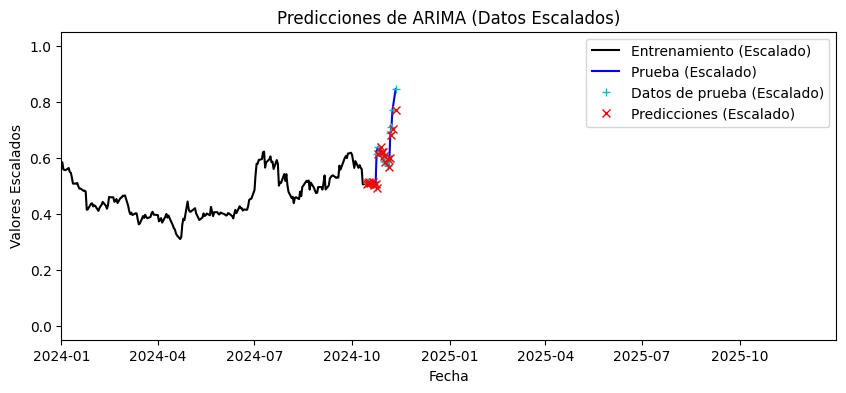

In [ ]:
# Gráfico de predicciones de Arima para datos escalados
fig, ax = plt.subplots(figsize=(10, 4))

# Graficamos las series de datos
ax.plot(train['y_escalada'], '-k', label='Entrenamiento (Escalado)')
ax.plot(test['y_escalada'], '-b', label='Prueba (Escalado)')
ax.plot(test['y_escalada'], '+c', label='Datos de prueba (Escalado)')
ax.plot(test.index, predictions_y_escalada, 'xr', label='Predicciones (Escalado)')

# Establecemos los límites de fechas en el eje x
ax.set_xlim(['2024-01-01', '2025-12-31'])

# Añadimos etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Valores Escalados')
ax.set_title('Predicciones de ARIMA (Datos Escalados)')
ax.legend()

plt.show()

# **3 - Modelo Facebook-Meta-Prophet**

#### **En la liga del modelo Facebook-Prophet puedes encontrar mucho más información, además de la documentación correspondiente:**

https://facebook.github.io/prophet/

In [21]:
# Prophet requiere que la entrada sean dos columnas, llamadas "ds" y "y".
# Les dmos esta forma usando el DataFrame "df" inicial:

# Para la columna 'y'
train_y = pd.DataFrame(df_temp['y'].iloc[0:-20])
test_y = pd.DataFrame(df_temp['y'].iloc[-20:])
train_y.reset_index(inplace=True)
test_y.reset_index(inplace=True)

# Para la columna 'y_escalada'
train_y_escalada = pd.DataFrame(df_temp['y_escalada'].iloc[0:-20])
test_y_escalada = pd.DataFrame(df_temp['y_escalada'].iloc[-20:])
train_y_escalada.reset_index(inplace=True)
test_y_escalada.reset_index(inplace=True)

#Renombra la columna
train_y_escalada.rename(columns = {'y_escalada':'y'}, inplace=True)
test_y_escalada.rename(columns = {'y_escalada':'y'}, inplace=True)

# Eliminar el timezone de la columna 'ds' (si es un datetime con zona horaria)
train_y['ds'] = train_y['ds'].dt.tz_localize(None)
test_y['ds'] = test_y['ds'].dt.tz_localize(None)
train_y_escalada['ds'] = train_y_escalada['ds'].dt.tz_localize(None)
test_y_escalada['ds'] = test_y_escalada['ds'].dt.tz_localize(None)


In [57]:
# Aplicamos el modelo Facebbok-Prophet a nuestros datos:no escalados

model = Prophet(seasonality_mode='multiplicative',
                daily_seasonality=True,
                changepoint_prior_scale=100,   # Controla la flexibilidad de la componente Trend, mayor valor mayores fluctuaciones.
                seasonality_prior_scale=100    # Controla la estacionalidad, mayor el valor, mayor flexibilidad en la estacionalidad.
                )

model.fit(train_y)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfh4z21lk/q98qtkn4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfh4z21lk/ow6tvfgp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54839', 'data', 'file=/tmp/tmpfh4z21lk/q98qtkn4.json', 'init=/tmp/tmpfh4z21lk/ow6tvfgp.json', 'output', 'file=/tmp/tmpfh4z21lk/prophet_modelmnwag9fa/prophet_model-20241112233908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:39:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:39:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [58]:
# Calculamos el error RMSE para datos NO escalados:

pred_FP = model.predict(test_y)['yhat']
rmse = np.sqrt(mean_squared_error(test_y['y'], pred_FP))
print('\nError-Modelo-FacebookProphet_y: RMSE: %.3f' % rmse)


Error-Modelo-FacebookProphet_y: RMSE: 67.795


In [ ]:
# Aplicamos el modelo Facebbok-Prophet a nuestros datos: escalados

model_y_escalada = Prophet(seasonality_mode='multiplicative',
                daily_seasonality=True,
                changepoint_prior_scale=100,   # Controla la flexibilidad de la componente Trend, mayor valor mayores fluctuaciones.
                seasonality_prior_scale=100)    # Controla la estacionalidad, mayor el valor, mayor flexibilidad en la estacionalidad.
model_y_escalada.fit(train_y_escalada)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpzp6mce59/3afr2w1u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzp6mce59/gexqv534.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38263', 'data', 'file=/tmp/tmpzp6mce59/3afr2w1u.json', 'init=/tmp/tmpzp6mce59/gexqv534.json', 'output', 'file=/tmp/tmpzp6mce59/prophet_modelabrjqowc/prophet_model-20241111222617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:26:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:26:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Calculamos el error RMSE para datos escalados:

pred_FP_escalado = model_y_escalada.predict(test_y_escalada)['yhat']
rmse = np.sqrt(mean_squared_error(test_y_escalada['y'], pred_FP_escalado))
print('\nError-Modelo-FacebookProphet_y_escalada: RMSE: %.3f' % rmse)


Error-Modelo-FacebookProphet_y_escalada: RMSE: 0.094


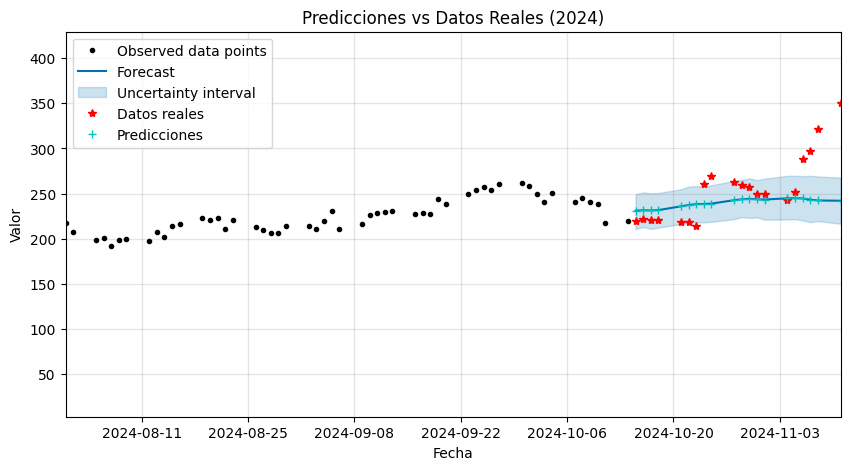

In [ ]:
# Gráfica de Datos NO escalados
forecast = model.predict(test_y)

fig, ax = plt.subplots(figsize=(10, 5))
model.plot(forecast, ax=ax)  # Gráfica de predicciones junto con la región de variabilidad.

# Agregar los datos reales de prueba sin sobrescribir 'ax'
ax.plot(test_y['ds'], test_y['y'], '*r', label='Datos reales')  # Datos de prueba (Test) con puntos rojos.
ax.plot(test_y['ds'], forecast['yhat'], '+c', label='Predicciones')  # Predicciones.

# Limitar el eje x al año 2024
ax.set_xlim(['2024-08-01', '2024-11-11'])

# Añadir leyenda, etiquetas y título
ax.legend()
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
plt.title('Predicciones vs Datos Reales (2024)')

plt.show()

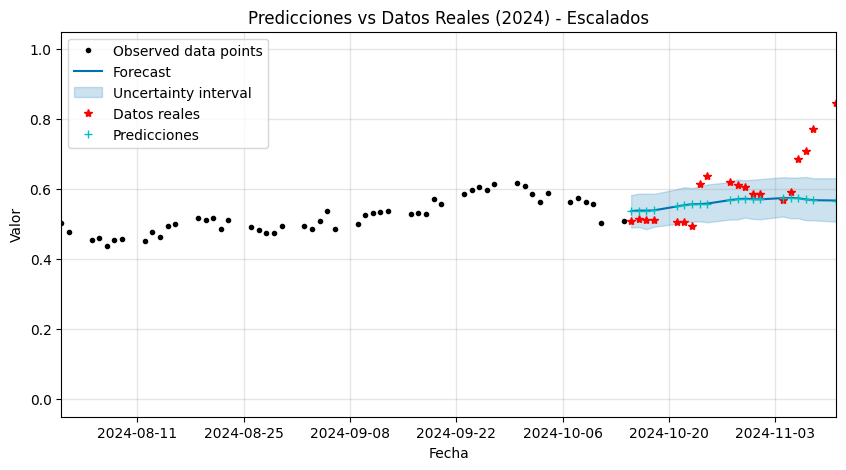

In [ ]:
# Gráfica de Datos escalados
forecast_scaled = model_y_escalada.predict(test_y_escalada)

fig, ax = plt.subplots(figsize=(10, 5))
model_y_escalada.plot(forecast_scaled, ax=ax)  # Gráfica de predicciones con su región de variabilidad.

# Agregar los datos reales de prueba sin sobrescribir 'ax'
ax.plot(test_y_escalada['ds'], test_y_escalada['y'], '*r', label='Datos reales')  # Datos de prueba (Test) con puntos rojos.
ax.plot(test_y_escalada['ds'], forecast_scaled['yhat'], '+c', label='Predicciones')  # Predicciones.

# Limitar el eje x al año 2024
ax.set_xlim(['2024-08-01', '2024-11-11'])

# Añadir leyenda, etiquetas y título
ax.legend()
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
plt.title('Predicciones vs Datos Reales (2024) - Escalados')

plt.show()

# **4 - Long Short Term Memory (LSTM)**

In [59]:
import tensorflow as tf

In [108]:
df_LSTM_y = df_temp.drop(columns=['y_escalada'])
df_LSTM_y.reset_index(inplace=True)

In [109]:
def preparando_datos(myData, myDate):

  # ++++++++ TRAIN +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Los datos de entrenamiento son previos a la fecha "Date" que indiques y
  # tomarán hisotriales en este caso de 12 períodos previos.
  Train_Data = myData['y'][myData['ds'] < myDate].to_numpy()

  periodo = 1   # se utilizan observaciones diarias

  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []

  for i in range(0, len(Train_Data), periodo):    # observa que va formando el Train set con historiales de 12 períodos consecutivos.
    try:
      Data_Train.append(Train_Data[i : i + periodo])
    except:
      pass


  # En ocasiones hay datos perdidos, en cuyo caso la última serie
  # de datos la eliminamos:
  if len(Data_Train[-1]) < periodo:
    Data_Train.pop(-1)


  # Hay que darle la forma (dimensionalidad) que requieren los modelos
  # de aprendizaje profundo, en particular la librería de TensorFlow:
  #     (batch_size, sequence_length, input_dimension).

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, periodo, 1))

  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, periodo, 1))


  # +++++++++++ TEST +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Los datos de prueba (Test) son posteriores a la fecha "Date" y que es el
  # último ciclo que deseas predecir:
  Test_Data = myData['y'][myData['ds'] >= myDate].to_numpy()

  # inicialización de listas:
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []

  for i in range(0, len(Test_Data), periodo):
    try:
      Data_Test.append(Test_Data[i : i + periodo])
    except:
      pass


  if len(Data_Test[-1]) < periodo:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, periodo, 1))

  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, periodo, 1))


  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

In [110]:
# Podemos definir la manera en que el tamaño de paso (learning-rate) varíe
# en cada época. Es usual definir también algunas funciones, exponenciales,
# por ejemplo. Por el momento definamos valores constantes por intervalos:

def scheduler(epoch):

  if epoch <= 100:
    lrate = 0.05
  elif epoch <= 180:
    lrate = 0.0005
  elif epoch <=190:
    lrate = 0.00005
  else:
    lrate = (10 ** -5)

  return lrate


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [111]:
def myModel():
    model = tf.keras.models.Sequential([
        # Única capa LSTM
        tf.keras.layers.LSTM(
            100,                              # Unidades suficientes para captar patrones complejos
            input_shape=(20, 1),              # Forma de entrada ajustada según los datos de entrada
            activation=tf.nn.leaky_relu,      # Función de activación
            return_sequences=False            # return_sequences=False ya que es la única capa LSTM
        ),
        tf.keras.layers.BatchNormalization(), # Normalización de la capa para estabilizar el entrenamiento
        tf.keras.layers.Dropout(0.2),         # Dropout para prevenir sobreajuste

        # Capa densa para la salida final
        tf.keras.layers.Dense(50, activation=tf.nn.leaky_relu),  # Capa densa con 50 unidades para representar patrones complejos
        tf.keras.layers.Dropout(0.1),                            # Dropout para regularización ligera
        tf.keras.layers.Dense(1)                                 # Capa de salida con activación lineal para regresión
    ])

    return model


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [112]:
# Continuemos con el DataFrame a partir de datos no escalados:

threshold_Date = df_LSTM_y.iloc[-21]['ds']   # A partir de esta fecha se empieza a generar el Test.
                                # En este caso, el Text_X serán los 20 ultimos precios

# Recuerda que la columna de fechas del DataFrame df, debe ser de tipo DateTime.

Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df_LSTM_y, threshold_Date)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 21290.2910 - root_mean_squared_error: 139.8556 - val_loss: 62942.4766 - val_root_mean_squared_error: 250.8834 - learning_rate: 0.0500
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1165.1982 - root_mean_squared_error: 34.1226 - val_loss: 5824.9893 - val_root_mean_squared_error: 76.3216 - learning_rate: 0.0500
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1455.0278 - root_mean_squared_error: 38.0509 - val_loss: 502.3785 - val_root_mean_squared_error: 22.4138 - learning_rate: 0.0500
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1461.8633 - root_mean_squared_error: 38.1542 - val_loss: 355.1003 - val_root_mean_squared_error: 18.8441 - learning_rate: 0.0500
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1361.7142 - root_mean_squared_error: 36.8273 - val_loss: 1943.3562 - val_root_mean_squared_error: 44.0835 - learning_rate: 0.0500
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

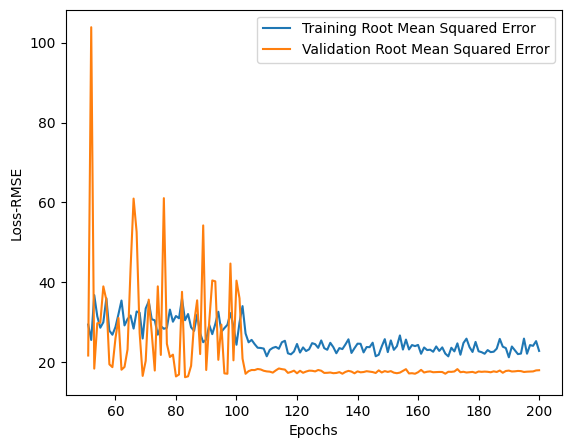

In [113]:
#Obten el modelo y genera la gráfica
my_LSTM_model2 = myModel()

my_LSTM_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='mse',    # función de costo "mse"
                      metrics=[tf.keras.metrics.RootMeanSquaredError()]   #  RMSE- despliega
                      )


H = my_LSTM_model2.fit(Train_X,
                       Train_Y,
                       epochs=200,
                       validation_data=(Test_X, Test_Y),
                       callbacks=[callback],

                       )



N = 50  # Para omitir los N primeros valores en la gráfica, que en ocasiones son
        # demasiado grandes los errores y no dejan apreciar las curvas de aprendizaje.

epochs = range(N+1, len(H.history["loss"]) + 1)

fig, ax2 = plt.subplots()
fig.set_figheight(5)
ax2.plot(epochs, H.history["root_mean_squared_error"][N:], label = "Training Root Mean Squared Error")
ax2.plot(epochs, H.history["val_root_mean_squared_error"][N:], label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss-RMSE")
ax2.legend()

plt.show()

In [115]:
# Calculamos el error RMSE:

#pred_LSTM = H.model.predict(Test_X)
pred_LSTM = my_LSTM_model2.predict(Test_X).reshape(-1)

rmse = np.sqrt(mean_squared_error(test['y'].values, pred_LSTM))

print('\nError-Modelo-LSTM, NO ESCALADOS: RMSE: %.3f' % rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Error-Modelo-LSTM, NO ESCALADOS: RMSE: 18.065


In [ ]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

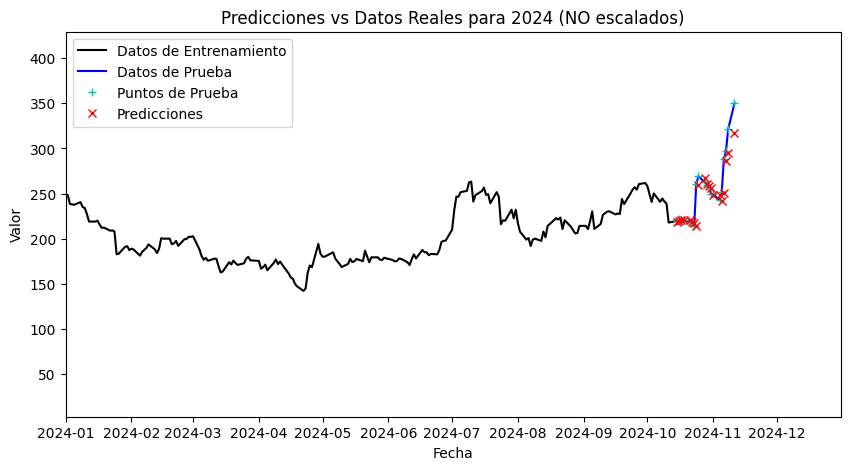

In [ ]:
# Graficamos los resultados:
fig, ax = plt.subplots(figsize=(10, 5))

# Graficamos las líneas
ax.plot(train['ds'], train['y'], '-k', label='Datos de Entrenamiento')  # Datos de entrenamiento
ax.plot(test['ds'], test['y'], '-b', label='Datos de Prueba')    # Datos de prueba
ax.plot(test['ds'], test['y'], '+c', label='Puntos de Prueba')    # Puntos de prueba
ax.plot(test['ds'], pred_LSTM, 'xr', label='Predicciones')  # Predicciones

# Limitar el eje X a las fechas del año 2024
ax.set_xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-12-31'))

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
plt.title('Predicciones vs Datos Reales para 2024 (NO escalados)')
ax.legend()

plt.show()

In [ ]:
#Repitiendo la operación para datos escalados
df_LSTM_y_escalada = df_temp.drop(columns=['y'])
df_LSTM_y_escalada.reset_index(inplace=True)
df_LSTM_y_escalada.rename(columns = {'y_escalada':'y'}, inplace=True)


In [ ]:
# Continuemos con el DataFrame a partir de datos escalados:

threshold_Date = df_LSTM_y_escalada.iloc[-21]['ds']   # A partir de esta fecha se empieza a generar el Test.
                                # En este caso, el Text_X serán los 20 ultimos precios

# Recuerda que la columna de fechas del DataFrame df, debe ser de tipo DateTime.

Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df_LSTM_y_escalada, threshold_Date)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1615 - root_mean_squared_error: 0.3891 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0907 - learning_rate: 0.0500
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0139 - root_mean_squared_error: 0.1170 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904 - learning_rate: 0.0500
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - root_mean_squared_error: 0.1077 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0889 - learning_rate: 0.0500
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0098 - root_mean_squared_error: 0.0984 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886 - learning_rate: 0.0500
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - root_mean_squared_error: 0.1019 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0873 - learning_rate: 0.0500
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - root_mean_squared_error: 0.1012 - val_

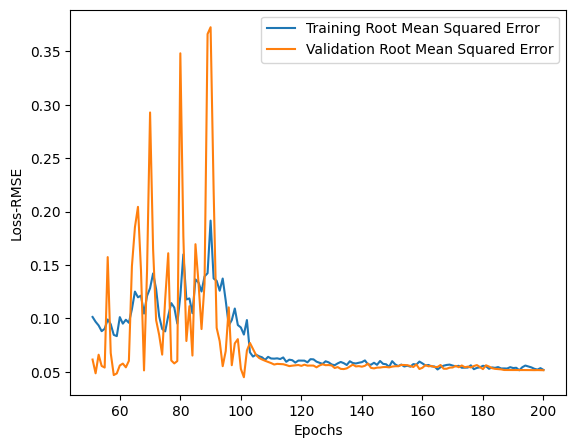

In [ ]:
#Obten el modelo y genera la gráfica
my_LSTM_model2_scaled = myModel()


my_LSTM_model2_scaled.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='mse',    # función de costo "mse"
                      metrics=[tf.keras.metrics.RootMeanSquaredError()]   #  RMSE- despliega
                      )


H = my_LSTM_model2_scaled.fit(Train_X,
                       Train_Y,
                       epochs=200,
                       validation_data=(Test_X, Test_Y),
                       callbacks=[callback],

                       )



N = 50  # Para omitir los N primeros valores en la gráfica, que en ocasiones son
        # demasiado grandes los errores y no dejan apreciar las curvas de aprendizaje.

epochs = range(N+1, len(H.history["loss"]) + 1)

fig, ax2 = plt.subplots()
fig.set_figheight(5)
ax2.plot(epochs, H.history["root_mean_squared_error"][N:], label = "Training Root Mean Squared Error")
ax2.plot(epochs, H.history["val_root_mean_squared_error"][N:], label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss-RMSE")
ax2.legend()

plt.show()

In [ ]:
# Calculamos el error RMSE:

#pred_LSTM = H.model.predict(Test_X)
pred_LSTM_scaled = my_LSTM_model2_scaled.predict(Test_X).reshape(-1)

rmse = np.sqrt(mean_squared_error(test['y_escalada'].values, pred_LSTM_scaled))

print('\nError-Modelo-LSTM, ESCALADOS: RMSE: %.3f' % rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step

Error-Modelo-LSTM, ESCALADOS: RMSE: 0.051


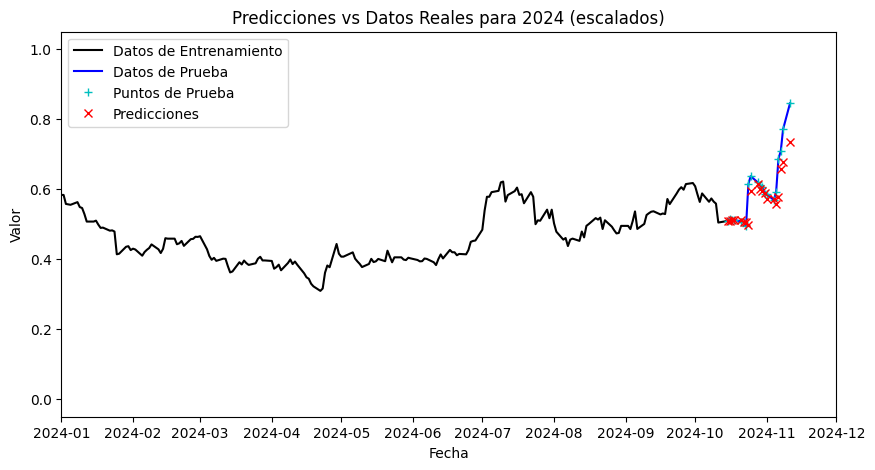

In [ ]:
# Graficamos los resultados:
fig, ax = plt.subplots(figsize=(10, 5))

# Graficamos las líneas
ax.plot(train['ds'], train['y_escalada'], '-k', label='Datos de Entrenamiento')  # Datos de entrenamiento
ax.plot(test['ds'], test['y_escalada'], '-b', label='Datos de Prueba')    # Datos de prueba
ax.plot(test['ds'], test['y_escalada'], '+c', label='Puntos de Prueba')    # Puntos de prueba
ax.plot(test['ds'], pred_LSTM_scaled, 'xr', label='Predicciones')  # Predicciones

# Limitar el eje X a las fechas del año 2024
ax.set_xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-12-01'))

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
plt.title('Predicciones vs Datos Reales para 2024 (escalados)')
ax.legend()

plt.show()

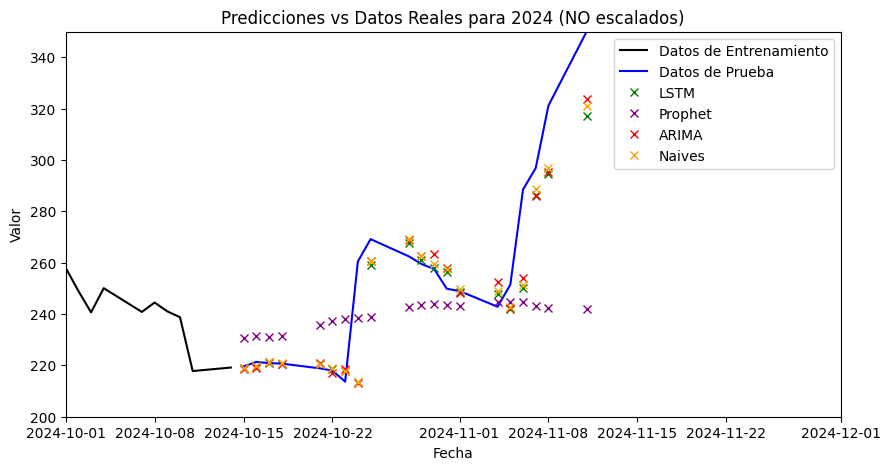

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Graficamos las líneas
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train['ds'], train['y'], color='black', linestyle='-', label='Datos de Entrenamiento')  # Datos de entrenamiento
ax.plot(test['ds'], test['y'], color='blue', linestyle='-', label='Datos de Prueba')           # Datos de prueba
ax.plot(test['ds'], pred_LSTM, color='green', marker='x', linestyle='', label='LSTM')  # Predicciones LSTM
ax.plot(test['ds'], forecast['yhat'], color='purple', marker='x', linestyle='', label='Prophet')  # Predicciones Prophet
ax.plot(test['ds'], predictions_y, color='red', marker='x', linestyle='', label='ARIMA')  # Predicciones Arima.
ax.plot(test['ds'], predictions_y_naives, color='orange', marker='x', linestyle='', label='Naives')  # Predicciones Arima.

# Limitar el eje X a las fechas del año 2024
ax.set_xlim(pd.to_datetime('2024-10-01'), pd.to_datetime('2024-12-01'))

#Limitar eje y
ax.set_ylim(200, 350)

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
plt.title('Predicciones vs Datos Reales para 2024 (NO escalados)')
ax.legend()



# Limitar el zoom en un rango específico
axins.set_xlim(pd.to_datetime('2024-10-15'), pd.to_datetime('2024-10-30'))
axins.set_ylim(min(test['y']), max(test['y']))  # Ajusta según los valores que quieras mostrar en el zoom
axins.set_xticklabels([])  # Quitar etiquetas para no sobrecargar el zoom
axins.set_yticklabels([])

plt.show()

**CONCLUSIONES:**

Resultados:

**Valores de RMSE para los diferentes moodelos:**

Naives: 16.416,
Naives_escalado: 0.042

Arima: 16.398  ******** Mejor Modelo *************,
Arima_escalado: 0.043

Prophet: 36.611,
Prophet escalado: 0.094

LSTM: 17.156 ,
LSTM escalado: 0.051

En este caso el modelo Arima tuvo mayor precisión aunque no por mucha diferencia respecto al LSTM.

El escalado NO mejora significativamente los modelos, como se observa en las gráficas, el comportamiento es prácticamente el mismo, además si se considera el RMSE como un porcentaje de los valores máximos se obtiene prácticamente la misma proporción.

LSTM mostró un desempeño competitivo sin escalado, lo que sugiere que las redes neuronales recurrentes trabajaron bien con los datos en su escala original sin requerir una transformación.

El problema en LSTM es que con datos pequeños al tratarse en redes neuronales pueden hacerse cada vez mas pequeños durante las operaciones pudiendose tener problemas de underflow lo que puede generar pérdida de precisión en los cálculos incrementando el margen de error en las predicciones, por lo que si un escalado ayuda lo mejor es que sean intervalos que se puedan manejar computacionalmente.

